In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd "/content/gdrive/MyDrive/FYP"

/content/gdrive/MyDrive/FYP


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from PIL import Image
from torchsummary import summary

1. Class Radiography Dataset

In [4]:
class RadiographyDataset(Dataset):

    def __init__(self, root, transform=None):
        super().__init__()
        self.data = []
        self.labels = []
        self.transform = transform
        self.classes   = os.listdir(root)

        #get the training samples
        for class_id, cls in enumerate(self.classes):

          cls_folder = os.path.join(root, cls)

          #get the training samples for the class 'cls'
          for img_name in os.listdir(cls_folder):
            self.data.append(os.path.join(cls_folder, img_name))
            self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        # get the image
        image = Image.open(self.data[idx])
        image = image.convert('RGB')
        
        # perform transformation
        if self.transform is not None:
          image = self.transform(image)
        
        # get the label
        label = self.labels[idx]
        
        return image, label

2. Create Efficientnet model

In [5]:
net = models.efficientnet_b0(weights='IMAGENET1K_V1')
in_c = net.classifier[1].in_features 
net.classifier[1] = nn.Sequential(
    nn.Linear(in_c, 1),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.2MB/s]


The model layout

In [6]:
net = net.cuda()
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

3. Set the optimizer and scheduler

In [7]:
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train / Fine Tune model

In [17]:
def train(model, trainloader, valloader, num_epochs, lr=0.01, momentum=0.9, step_size=10, gamma=0.1):
    
    train_history = []  # save the train loss
    val_history = []    # save the validation loss
    
    # transfer model to GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = torch.device("cpu")
    
    model = model.to(device)

    #Set the optimizer and scheduler    
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # train the network
    for e in range(num_epochs):

        #running_loss
        running_loss = 0.0
        running_count = 0.0
        running_val_loss = 0.0
        running_val_count = 0.0

        #----------------------------train---------------------------------------
        # set to training mode
        model.train()

        for i, (inputs, labels) in enumerate(trainloader):

            labels = labels.reshape(-1, 1).float()
            
            # Clear all the gradient to 0
            optimizer.zero_grad()

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = model(inputs)
            #labels = labels.to(torch.float32)
        
            # compute loss 
            loss = F.binary_cross_entropy(outs, labels)

            # backpropagation to get dw
            loss.backward()

            # update the parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

        # compute the averaged loss in each epoch
        train_loss = running_loss / running_count
        train_history.append(train_loss)
        running_loss = 0. 
        running_count = 0.     

        # Update the scheduler's counter at the end of each epoch
        scheduler.step()

        #-----------------------validation---------------------------------------
        # set to eval mode
        model.eval()

        for i, (inputs, labels) in enumerate(valloader):

            labels = labels.reshape(-1, 1).float()

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = model(inputs)
            #labels = labels.to(torch.float32)
        
            # compute loss 
            loss_val = F.binary_cross_entropy(outs, labels)

            # get the loss
            running_val_loss += loss_val.item()
            running_val_count += 1

        # compute the averaged loss in each epoch
        val_loss = running_val_loss / running_val_count
        val_history.append(val_loss)
        running_val_loss = 0. 
        running_val_count = 0.
        print(f'Epoch {e+1:2d}/{num_epochs:d} : train_loss = {train_loss:.4f} | val_loss = {val_loss:.4f}')

        # create save model folder
        if not os.path.exists("./efficientnet_models"):
          os.mkdir("efficientnet_models")

        # save the model       
        checkpoint_file = './efficientnet_models/saved_model.pt'
        torch.save({
            'epoch': e,
            'train_loss': train_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_file)

    print("Training completed.")
    return train_history, val_history

Evaluate model

In [9]:
def evaluate(model, testloader):
    # set to evaluation mode
    model.eval()
    
    # running_correct
    running_corrects = 0
    running_count = 0

    for inputs, targets in testloader:
        
        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = model(inputs)
            predicted = outputs > 0.5
            running_corrects += (predicted.view(-1) == targets).sum().double()
            running_count += len(inputs)
            print('.', end='')

    print('\nAccuracy = {:.2f}%'.format(100*running_corrects/running_count))

# Loss graph

In [10]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss)+1)
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.ylabel('Loss', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Loss vs epoch', fontsize=18)
    plt.legend()
    plt.show()

# Accurarcy graph

In [11]:
def plot_history_acc(train_acc, val_acc):
    epochs = range(1, len(train_acc)+1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_acc, color='red', label='train_acc')
    plt.plot(epochs, val_acc, color='blue', label='val_acc')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()

Check the dataset images number

In [12]:
classes = ['COVID', 'Normal', 'Viral Pneumonia']

total_ori = 0
ori_path = './COVID-19_Radiography_Dataset/'
for cls in classes:
  total_ori += len(os.listdir(ori_path + cls + '/images'))
print('Total of original datasets         : ', total_ori)
print('---------------------------------------------\n')

print('Train-Covid                        : ', len(os.listdir('./Radiography_Data/train/COVID')))
print('Train-Normal                       : ', len(os.listdir('./Radiography_Data/train/Normal')))
print('Train-Viral Pneumonia              : ', len(os.listdir('./Radiography_Data/train/Viral Pneumonia')))

print('\nValidation-Covid                   : ', len(os.listdir('./Radiography_Data/val/COVID')))
print('Validation-Normal                  : ', len(os.listdir('./Radiography_Data/val/Normal')))
print('Validation-Viral Pneumonia         : ', len(os.listdir('./Radiography_Data/val/Viral Pneumonia')))

print('\nTest-Covid                         : ', len(os.listdir('./Radiography_Data/test/COVID')))
print('Test-Normal                        : ', len(os.listdir('./Radiography_Data/test/Normal')))
print('Test-Viral Pneumonia               : ', len(os.listdir('./Radiography_Data/test/Viral Pneumonia')))

print('---------------------------------------------\n')
new_path = './Radiography_Data/'
folder = ['train', 'val', 'test']
total_new = 0
for fld in folder:
  for cls in classes:
    total_new += len(os.listdir(new_path + fld + '/' + cls))

print('Total of Train, Val, Test datasets : ', total_new)

Total of original datasets         :  15153
---------------------------------------------

Train-Covid                        :  2892
Train-Normal                       :  8153
Train-Viral Pneumonia              :  1076

Validation-Covid                   :  362
Validation-Normal                  :  1019
Validation-Viral Pneumonia         :  134

Test-Covid                         :  362
Test-Normal                        :  1020
Test-Viral Pneumonia               :  135
---------------------------------------------

Total of Train, Val, Test datasets :  15153


Transformation of images

In [13]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
train_transform = transforms.Compose([
    transforms.Resize(256),                                # output: PIL Image of resolution(256, 256)
    transforms.RandomCrop(224),                            # output: PIL Image of resolution(224, 224)
    transforms.RandomHorizontalFlip(),                     # output: PIL Image of resolution(224, 224)
    transforms.ToTensor(),                                 # output: tensor, dtype = float32, shape = (3, 224, 224), range:[0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # output: same as before except range changes such that mean = 0, std = 1
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Load the dataset using DataLoader

In [14]:
#Load the dataset
trainset = RadiographyDataset("./Radiography_Data/train", transform=train_transform)
valset  = RadiographyDataset("./Radiography_Data/val", transform=val_transform)

batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader  = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

Start training

In [18]:
# Release Cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [19]:
train_loss, val_loss = train (net, trainloader, valloader, num_epochs=30)

Epoch  1/30 : train_loss = -7.6192 | val_loss = -8.3509
Epoch  2/30 : train_loss = -8.4987 | val_loss = -8.5468
Epoch  3/30 : train_loss = -8.6302 | val_loss = -8.4047
Epoch  4/30 : train_loss = -8.6459 | val_loss = -8.3822
Epoch  5/30 : train_loss = -8.6816 | val_loss = -8.3631
Epoch  6/30 : train_loss = -8.7240 | val_loss = -8.3512
Epoch  7/30 : train_loss = -8.7839 | val_loss = -8.4981
Epoch  8/30 : train_loss = -8.7400 | val_loss = -8.6050
Epoch  9/30 : train_loss = -8.7732 | val_loss = -8.3730
Epoch 10/30 : train_loss = -8.7899 | val_loss = -8.5622
Epoch 11/30 : train_loss = -8.7878 | val_loss = -8.4441
Epoch 12/30 : train_loss = -8.8422 | val_loss = -8.8207
Epoch 13/30 : train_loss = -8.8397 | val_loss = -8.6950
Epoch 14/30 : train_loss = -8.8560 | val_loss = -8.4464
Epoch 15/30 : train_loss = -8.8520 | val_loss = -8.5700
Epoch 16/30 : train_loss = -8.8475 | val_loss = -8.5694
Epoch 17/30 : train_loss = -8.8529 | val_loss = -8.5675
Epoch 18/30 : train_loss = -8.8237 | val_loss = 

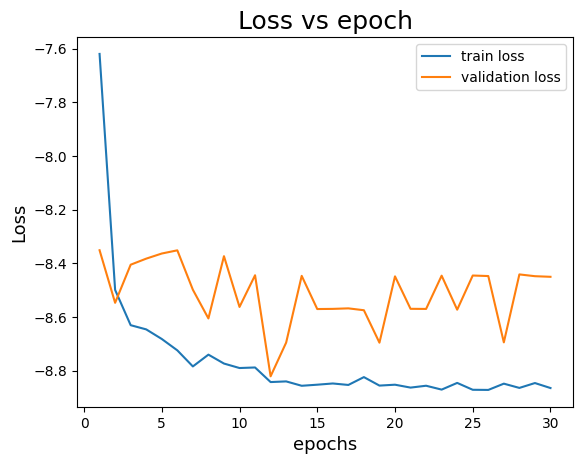

In [20]:
plot_loss(train_loss, val_loss)

In [ ]:
#plot_history_acc(train_acc, val_acc)

Evaluate model

In [21]:
# transform the model
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32
testset = RadiographyDataset("./Radiography_Data/test", transform=test_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [22]:
evaluate(net, testloader)

................................................
Accuracy = 90.44%
